# Simple wall
This tutorial presents how to obtain steady-state and dynamic thermal model for a simple wall which has capacities in all nodes and has as boundary conditions temperature, on one side, and heat flow rate, on the other. The dynamic responses are obtained by numerical integration using Euler explicit and implicit methods. The response of the building is studied for a step input and for outdoor temperature taken from weather data. The problems of numerical stability and the choice of the time-step for integration are discussed.

## Physical characteristics and mathematical model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

# Physical properties
# ===================
wall = {'Conductivity': [1.400, 0.040],
        'Density': [2300.0, 16.0],
        'Specific heat': [880, 1210],
        'Width': [0.2, 0.08],
        'Slices': [4, 2]}
wall = pd.DataFrame(wall, index=['Concrete', 'Insulation'])

air = {'Density': 1.2,
       'Specific heat': 1000}

Let’s consider the heat transfer through a wall which separates the outside air, at temperature $T_o$ from the inside air. Heat $Q_h$ is added to the inside air by a fan-coil (see figure).

![wall](t02_wall.png)
> Simple wall and its thermal network model. The concrete wall is divided in four slices and the insulation in two.

The thermal properties of the wall and of the air are:

In [2]:
wall

,Conductivity,Density,Specific heat,Width,Slices
Concrete,1.40,2300.0,880,0.20,4
Insulation,0.04,16.0,1210,0.08,2


In [3]:
air

{'Density': 1.2, 'Specific heat': 1000}

We'll consider the convection coefficients for indoor and outdoor:

In [4]:
# convection coefficients, W/m² K
h = pd.DataFrame([{'in': 4., 'out': 10}])

The dimensions of the wall are 3 x 3 m² and the volume of the indoor air is 3 x 3 x 3 m³.

In [5]:
S_wall = 3 * 3      # m²
V_air = 3 * 3 * 3   # m³

## Thermal network model


The wall cinsists in two layers: concrete and insulation. The concrete layer is discretized in 4 slices and the insulation layer in 2 slices. By adding together the resistances which are in series, the following thermal nework is obtained:
![RC](t02_RC_model.png)
> Thermal nework model of a simple wall obtained by considering the equivalent resistances of the resistanaces in series. The model contains capacities in every node.

The circuit elements of the thermal network are the resistances and the capacities. Their values are found by using the thermo-physical properties of the materials.

### Resistances and capacities in the thermal network

The thermal resistances for conduction are of the form:
$$R_{cd} = \frac{w}{\lambda S}$$
where:

- $w$ is the width of the material, m;
- $\lambda$ - thermal conductvity, W/m K;
- $S$ - surface area of the wall, m²

In [6]:
# conduction
R_cd = wall['Width'] / (wall['Conductivity'] * S_wall)

The thermals resistance for convection are of the form:
$$R_{cv} = \frac{1}{h S}$$
where:
- $h$ is the convection coefficient, W/m² K;
- $S$ - surface area of the wall, m².

In [7]:
# convection
R_cv = 1 / (h * S_wall)

The thermal capacities of the wall are of the form:
$$C_{wall}= \rho_{wall} c_{p, wall} w_{wall} S_{wall}$$

In [8]:
C_wall = wall['Density'] * wall['Specific heat'] * wall['Width'] * S_wall

The thermal capacity of the air is:
$$C_{air} = \rho_{air} c_{air} V_{air}$$

In [9]:
C_air = air['Density'] * air['Specific heat'] * V_air

## Differential algebraic equations (DAE)

The number of temperature nodes and of flow branches of the thermal network depend on the number of slices obtained by the discretization of the wall:

In [10]:
# number of temperature nodes and flow branches
no_t = no_q = sum(wall['Slices']) + 1

### Conductance matrix **G**
The resistances are grouped in the conductance matrix, which is diagonal:
$$G = \begin{bmatrix}
R_0^{-1} &  &  & \\ 
 & R_1^{-1} &  & \\ 
 &  & ... & \\ 
 &  &  & R_{nq}^{-1}
\end{bmatrix}$$

where:
- $nq$ is the number of flow branches, $nq = 6$;
- $R_0 = R_{cv,out} + R_{cd,c} / 8$ ; this resistance is composed of outdoor convection and conduction in concrete; since the concrete is discretized in 4 slices, there are 8 resistances, each one of value $R_{cd,c} / 8$;
- $R_1 = R_2 = R_3 = R_{cd,c} / 4$; two resiatances $R_{cd,c} / 8$ are added, resulting in $R_{cd,c} / 4$;
- $R_4 = R_{cd,c} / 8 + R_{cd,i} / 4$; this resistance is formed by a slice of concrete and a slice of insulation;
- $R_5 = R_{cd,i} / 2$; two slices of insulation, each one with resistance $R_{cd,i} / 4$, are in series; 
- $R_6 = R_{cd,i} / 4 + R_{cv,in}$ ; this resistance is composed of conduction in the insulation and convection at the inside surface of the wall.

*Note*: each branch of the network needs to have a resistance (or a conductance).

In [11]:
# Conductance matrix
R = np.zeros([no_q])
R[0] = R_cv['out'] + R_cd['Concrete'] / 8
R[1] = R[2] = R[3] = R_cd['Concrete'] / 4
R[4] = R_cd['Concrete'] / 8 + R_cd['Insulation'] / 4
R[5] = R_cd['Insulation'] / 2
R[6] = R_cd['Insulation'] / 4 + R_cv['in']
G = np.diag(np.reciprocal(R))

### Capacity matrix **C**
The capacities are grouped in the capacity matrix, which is diagonal:
$$C = \begin{bmatrix}
C_0 &  &  & \\ 
 & C_1 &  & \\ 
 &  & ... & \\ 
 &  &  & C_{nt}
\end{bmatrix}$$

where:
- $nt$ is the number of temperature nodes, $nt = 6$;
- $C_0 = C_1 = C_2 = C_3 = C_{wall, concrete} / 4$; since the concrete layer is divided in 4 slices, the capacity of a slice is 1/4 of the capacity of the concrete layer;
- $C_4 = C_5 = C_{wall, insulation} / 2$; since the insulation layer is divided in 2 slices, the capacity of a slice is 1/2 of the capacity of the insulation layer;
- $C_6 = C_{air}$.

*Note*: not every temperature node needs to have a capacity. The capacity of a surface is zero, since its volume and, consequently, its mass are zero.

In [12]:
C = np.zeros(no_t)
C[0] = C[1] = C[2] = C[3] = C_wall['Concrete'] / 4
C[4] = C[5] = C_wall['Insulation'] / 2
C[6] = C_air
C = np.diag(C)

### Arc-node incidence matrix $A$
The rows in the incidence matrix $A$ corespond to the branches containing the heat flow rates $q_k$ across the resistances $R_k$ and the columns correspond to the temperature nodes $\theta_l$. In the row corresponding to the branch $R_k$ in the position of the node $\theta_l$ there is -1 if the flow $q_k$ leaves the node, +1 if the flow $q_k$ enters into the node $\theta_k$ and 0 if the resistance $R_k$ is not connected to the temperature node $\theta_k$ [Ghiaus, 2013]:

$$a_{kl} = \begin{cases}
\phantom{-} 0 & \text{if flow branch } q_k \text{ is not connected to the temperature node }  \theta_l \\ 
+1 & \text{if flow branch } q_k \text{ enters into the temperature node }  \theta_l\\ 
-1 & \text{if flow branch } q_k \text{ gets out of the temperature node }  \theta_l 
\end{cases}$$

The matrix -$A$ is a difference operator for the temperatures: $e = -A \theta$ is the vector of differences between temperatures connected by resistances [Ghiaus, 2013].

In [13]:
A = np.eye(no_q, no_t + 1)
A = -np.diff(A, n=1, axis=1)
print(A)

[[ 1. -0. -0. -0. -0. -0. -0.]
 [-1.  1. -0. -0. -0. -0. -0.]
 [-0. -1.  1. -0. -0. -0. -0.]
 [-0. -0. -1.  1. -0. -0. -0.]
 [-0. -0. -0. -1.  1. -0. -0.]
 [-0. -0. -0. -0. -1.  1. -0.]
 [-0. -0. -0. -0. -0. -1.  1.]]


### Vectors of temperature sources **b** and flows **f**
First, we will set all the temperature sources **b** and flow sources **f** to zero:

In [14]:
b = np.zeros(no_q)
f = np.zeros(no_t)

Their values will be changed depending on the conditions.

The system of Algebraic-Differential Equations is:

$$C\dot{\theta} = -A^T G A \theta + A^T G b + f$$

## Steady state solution

The solution in steady-state is:

$$\theta = (A^T G A)^{-1}(A^T G b + f)$$
$$q = G (-A \theta + b)$$

We will consider two steady states: 
1) The outdoor temperature is 1 °C, $b_0 = 1$.

In [15]:
b[0] = 1
temp_steady_To = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
np.set_printoptions(precision=3)
print('When To = 1°C, the temperatures in steady-state are:', temp_steady_To, '°C')
print(f'The indoor temperature is: {temp_steady_To[-1]:.3f} °C')

When To = 1°C, the temperatures in steady-state are: [1. 1. 1. 1. 1. 1. 1.] °C
The indoor temperature is: 1.000 °C


2. The indoor flow introduced by the fan-coil is 1 W, $f_6 = 1$.

In [16]:
b[0] = 0
f[-1] = 1
temp_steady_Qh = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print('When Qh = 1W, the temperatures in steady-state are:', temp_steady_Qh, '°C')
print(f'The indoor temperature is: {temp_steady_Qh[-1]:.3f} °C')

When Qh = 1W, the temperatures in steady-state are: [0.013 0.017 0.021 0.025 0.083 0.194 0.277] °C
The indoor temperature is: 0.277 °C


## State-space model
If the matrix $C$ is invertible (or non-singular), then the Differential-algebraic system of equations

$$C\dot{\theta} = -A^T G A \theta + A^T G b + f$$

can be put in the state-space representation

$$\left\{\begin{array}{rr}
\dot{\theta}=A_s \theta + B_s u\\ 
y = C_s \theta + D_s u
\end{array}\right.$$

where:
- $u = \begin{bmatrix} b \\ f\end{bmatrix}$ is the vector of inputs (temperature sources $b$ and flow sources $f$);
- $A_s = -C^{-1} A^T G A$ is the state matrix, $\dim A = n_\theta \times n_\theta$;
- $B_s = C^{-1}\begin{bmatrix}
A^T G & I
\end{bmatrix}$ is the input matrix, $\dim B = n_\theta \times n_u$;
- $C_s = \begin{bmatrix} 0 & 0 & ... &1 \end{bmatrix}$ is the output matrix, $\dim C = 1 \times n_\theta$;
- $D_s = \begin{bmatrix} 0 & 0 & ... &0 \end{bmatrix}$ is the feedthrough (or feedforward matrix, $\dim D = 1 \times n_u$.

The first equation, $ \dot{\theta}=A_s \theta + B_s u $, is called *state* or *system* equation and the second equation, $ y = C_s \theta + D_s u $, is calld *observation* equation,

The input matrix is
$B_s = C^{-1}\begin{bmatrix}
A^T G & I
\end{bmatrix}$

In [17]:
B = np.linalg.inv(C) @ np.block([A.T @ G, np.eye(no_t)])

The input vector if formed by stacking the vector of temperature sources $b$ and the vector of flow sources $f$:
$$u = \begin{bmatrix} b \\ f\end{bmatrix}$$

However, many sources in the model are zero. For our example, there are only two sources: $T_o$ and $Q_h$. Therefore,
$$b = \begin{bmatrix}
T_o\\ 
0\\ 
...\\ 
0
\end{bmatrix}$$
and
$$f = \begin{bmatrix}
0\\ 
0\\ 
...\\ 
Q_h
\end{bmatrix}$$

Since the sources which are always zero have no influence on the outputs, they cen be neglected. Only the columns that correspond to existing sources, i.e., the 1st and the last, are kept in matix $B$: 

In [18]:
# Select columns for which the input vector is not zero
# 1st for To and last for Qh
B = B[:, [0, -1]]

The state matrix is $A_s = -C^{-1} A^T G A$

In [19]:
# State matrix
A = -np.linalg.inv(C) @ A.T @ G @ A

The output matrix $C$ extracts the values of interest from the state vector (the vector of temperatures). In our case, the temperature of interest is the indoor temperature,
$$T_o \equiv  \theta_6 = \begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\theta_0\\ 
\theta_1\\ 
\theta_2\\ 
\theta_3\\ 
\theta_4\\ 
\theta_5\\ 
\theta_6
\end{bmatrix} = C \theta$$

which gives

$$C = \begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}$$

In [20]:
# Output matrix
C = np.zeros((1, no_t))
# output: last temperature node
C[:, -1] = 1

The feedthrough matrix $D$ has one row (the number of outputs) and two columns (the same as the number of columns of matrix $B$), which is the number of inputs $u$; in this case, $D$ is composed only of zeros:

In [21]:
# Feedthrough (or feedforward) matrix
D = np.zeros(B.shape[1])

## Eigenvalues, numerical stability and time-step

The stability condition for explicit Euler method requires that all eigenvalues $\lambda _i \in \mathbb{Z}$ of the state matrix $A$ satisfy the condition
$$ \left | 1 + \lambda _i \Delta t \right | \leq 1, \forall i $$

If the all eigenvalues of state matrix $A$ are real, as is the case for thermal networks, then the above condition becomes:
$$ -2 \leq \lambda _i\Delta t\leq 0, \forall i $$.

Since the eigenvalues $\lambda_i$ are related to time constants $T_i$,
$$ \lambda _i = - \frac{1}{T_i} $$
it results that the condition for stability is 
$$ \Delta t \leq \min T_i/2 = -2 / \min \lambda_i $$

In [22]:
max_dt = min(-2 / np.linalg.eig(A)[0])
print(f'Max time step dt: {max_dt:.2f} s')

Max time step dt: 416.11 s


We choose a time step smaller than the maximum admited for stability.

In [23]:
dt = 360
# dt = 416.5

## Time integration using explcit and implicit Euler methods
We will study the dynamics reponse of the of the model to: 
- a step variation of a source (outdoor temperature $T_o$ or indoor flow $Q_h$);
- variation of outdoor temperature given by weather data.

We want the weather data for Lyon from 10 April to 15 May. 

In [24]:
filename = 'FRA_Lyon.074810_IWEC.epw'
start_date = '2000-04-10'
end_date = '2000-05-15'

From the read data, only the air temperature, direct solar radiation on normal surface and diffuse solar radiation on horisontal surface are kept. 

In [25]:
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

Each month in the weather data is taken from another year. We will replace the years with only one value, e.g. 2000, then keep ony the values between `start_date` and `end_date`.

In [26]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(weather.index >= start_date) & (
    weather.index < end_date)]

Since the data is given hourly, the number of days in the simulation will be:

In [27]:
days = weather.shape[0] / 24
days

35.0

The number of steps and the time vector will be

In [28]:
# number of steps
n = int(np.floor(3600 / dt * 2 * days))
# time
t = np.arange(0, n * dt, dt)

### Step input: outdoor temperature $T_o$

Let's consider that the outdoor temperature $T_o$ has a step variation of 1°C (the indoor heat flow is zero, $Q_h = 0$:

In [29]:
u = np.block([[np.ones([1, n])],
              [np.zeros([1, n])]])

We initialize to zero the temperature vector for explicit and implicit Euler.

In [30]:
# initial values for temperatures obtained by explicit and implicit Euler
temp_exp = np.zeros([no_t, t.shape[0]])
temp_imp = np.zeros([no_t, t.shape[0]])

The formula for Euler forward (or explicit) integration is
$$ \theta_{k+1} = (I + \Delta t A) \theta _k + \Delta t B u_k $$
and for Euler backward (or implicit) integration it is
$$\theta_{k+1} = (I - \Delta t A)^{-1} ( \theta _k + \Delta t B u_k )$$

In [31]:
for k in range(t.shape[0] - 1):
    temp_exp[:, k + 1] = (np.eye(no_t) + dt * A) @\
        temp_exp[:, k] + dt * B @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(np.eye(no_t) - dt * A) @\
        (temp_imp[:, k] + dt * B @ u[:, k])

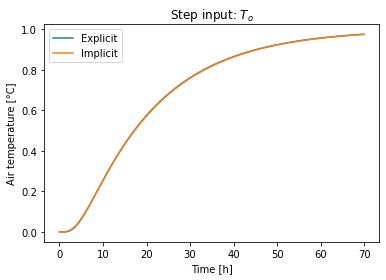

In [32]:
fig, ax = plt.subplots()
ax.plot(t / 3600, temp_exp[-1, :], t / 3600, temp_imp[-1, :])
ax.set(xlabel='Time [h]', ylabel='Air temperature [°C]', title='Step input: $T_o$')
ax.legend(['Explicit', 'Implicit'])

### Step input: indoor heat flow $Q_h$

Let's consider that the outdoor temperature $Q_h$ has a step variation of 1 W (the outdoor temperature is zero, $T_o = 0$:

In [33]:
u = np.block([[np.zeros([1, n])],
              [np.ones([1, n])]])

We initialize again to zero the temperature vector for explicit and implicit Euler.

In [34]:
temp_exp = np.zeros([no_t, t.shape[0]])
temp_imp = np.zeros([no_t, t.shape[0]])

The formula for Euler forward (or explicit) integration is
$$ \theta_{k+1} = (I + \Delta t A) \theta _k + \Delta t B u_k $$
and for Euler backward (or implicit) integration it is
$$\theta_{k+1} = (I - \Delta t A)^{-1} ( \theta _k + \Delta t B u_k )$$

In [35]:
for k in range(t.shape[0] - 1):
    temp_exp[:, k + 1] = (np.eye(no_t) + dt * A) @\
        temp_exp[:, k] + dt * B @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(np.eye(no_t) - dt * A) @\
        (temp_imp[:, k] + dt * B @ u[:, k])

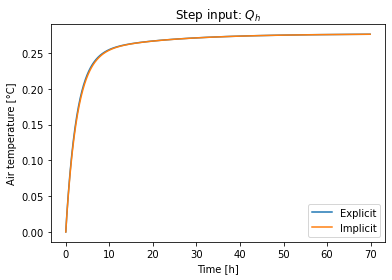

In [36]:
fig, ax = plt.subplots()
ax.plot(t / 3600, temp_exp[-1, :], t / 3600, temp_imp[-1, :])
ax.set(xlabel='Time [h]', ylabel='Air temperature [°C]', title='Step input: $Q_h$')
ax.legend(['Explicit', 'Implicit'])

### Simulation with outdoor temperature, $T_o$

Time vector (in seconds) for weather data:

In [37]:
tw = np.arange(0, 3600 * weather.shape[0], 3600)

Interpolate the outdoor tempertaure $T_o$ (which is at a time step of 1 h) to a time step equal to $dt$:

In [38]:
t = np.arange(0, 3600 * weather.shape[0], dt)
# outdoor temperature at timestep dt
temp_out = np.interp(t, tw, weather['temp_air'])

Form the input vector $u$ from outdoor temperature and indoor heat flow $Q_h$, which is zero:

In [39]:
u = np.block([[temp_out],
             [np.zeros(temp_out.shape[0])]])

Initialize the temperature vectors for explicit and implicit Euler and integrate.

In [40]:
temp_exp = np.zeros([no_t, t.shape[0]])
temp_imp = np.zeros([no_t, t.shape[0]])
for k in range(n - 1):
    temp_exp[:, k + 1] = (np.eye(no_t) + dt * A) @\
        temp_exp[:, k] + dt * B @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(np.eye(no_t) - dt * A) @\
        (temp_imp[:, k] + dt * B @ u[:, k])

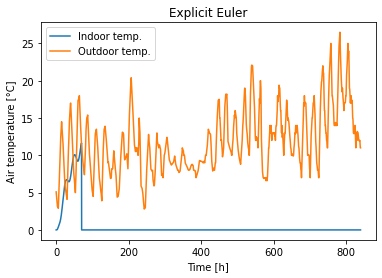

In [41]:
fig, ax = plt.subplots()
ax.plot(t / 3600, temp_exp[-1, :],
               t / 3600, temp_out)
ax.set(xlabel='Time [h]', ylabel='Air temperature [°C]', title='Explicit Euler')
ax.legend(['Indoor temp.', 'Outdoor temp.'])

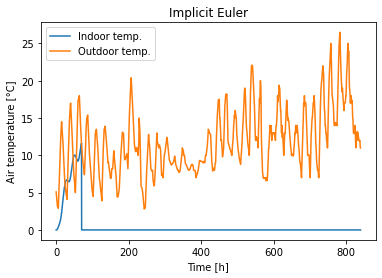

In [42]:
fig, ax = plt.subplots()
ax.plot(t / 3600, temp_imp[-1, :],
               t / 3600, temp_out)
ax.set(xlabel='Time [h]', ylabel='Air temperature [°C]', title='Implicit Euler')
ax.legend(['Indoor temp.', 'Outdoor temp.'])

**References**

C. Ghiaus (2013) Causality issue in he heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, https://doi.org/10.1016/j.energy.2012.10.024
